In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%debug

import warnings
warnings.filterwarnings('ignore')

ERROR:root:No traceback has been produced, nothing to debug.


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, balanced_accuracy_score, f1_score
from sklearn.metrics import make_scorer
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [3]:
data_path = "../data/adult.data"
data = pd.read_csv(data_path)

In [4]:
data.head(5)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,Salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [5]:
data.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'Salary'],
      dtype='object')

In [6]:
data.Salary.unique()
data["has_50k_salary"] = data["Salary"].apply(lambda x:  0 if x.strip() == "<=50K" else 1)

In [7]:
data[["has_50k_salary"]].groupby('has_50k_salary').size().reset_index(name="counts")

,has_50k_salary,counts
0,0,24720
1,1,7841


__The number of people in the sample who have less
than 50k salary is more than thrice as much people who have more than that.__

__What is the age distribution in the sample, Count of people with above and below 50k salary grouped by age__

In [8]:
bins = list(range(0,90,10))
data['bin'] = pd.cut(data['age'], bins)
grouped_salary_by_age = data.groupby(['bin','has_50k_salary']).size().reset_index(name="Count")
grouped_salary_by_age = grouped_salary_by_age.pivot(index='bin', columns='has_50k_salary').add_prefix('P').reset_index("bin")
grouped_salary_by_age.columns = grouped_salary_by_age.columns.get_level_values(0)
grouped_salary_by_age.columns = ['bin', 'below_50k', 'above_50k']
grouped_salary_by_age

,bin,below_50k,above_50k
0,"(10, 20]",2408,2
1,"(20, 30]",7482,680
2,"(30, 40]",6140,2406
3,"(40, 50]",4328,2655
4,"(50, 60]",2581,1547
5,"(60, 70]",1335,457
6,"(70, 80]",361,80


## Visualizations 1 and 2

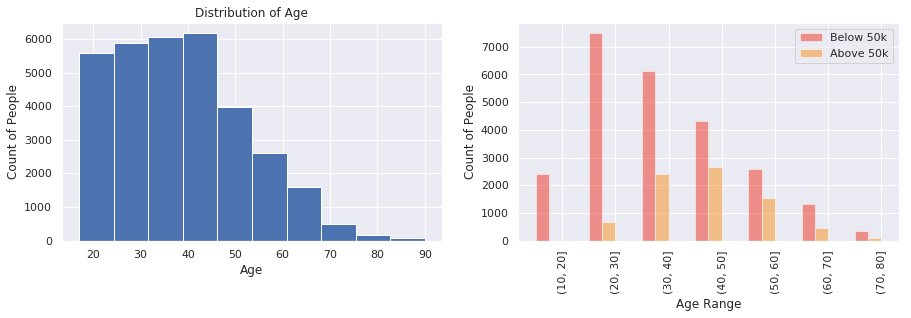

In [9]:
f = plt.figure(figsize=(15,4))

ax1 = f.add_subplot(121)
ax1.hist(data.age)
ax1.set_xlabel("Age")
ax1.set_ylabel("Count of People")
ax1.set_title("Distribution of Age")


pos = list(range(len(grouped_salary_by_age['bin']))) 
width = 0.25 

ax2 = f.add_subplot(122)
ax2.bar(pos, grouped_salary_by_age['below_50k'], width, alpha=0.5, color='#EE3224', label=grouped_salary_by_age['bin'][0]) 
ax2.bar([p + width for p in pos], grouped_salary_by_age['above_50k'], width, alpha=0.5, color='#F78F1E', label=grouped_salary_by_age['bin'][1]) 
ax2.set_ylabel('Count of People')
ax2.set_xlabel('Age Range')
ax2.set_xticks([p + 1.5 * width for p in pos])
ax2.set_xticklabels(grouped_salary_by_age['bin'], rotation=90)
ax2.legend(['Below 50k', 'Above 50k'], loc='upper right')

plt.show()

__The plot on the left shows the distribution of age in the dataset. As seen the number of people in the sample increases in every bin of 10 until 50. Number of people over 50 are less in the data.__

__In every age group the number of people whose salary is less than 50k is more than the counterpart. Most number of people whose salary is above 50k are in the range 40 - 50__

__Interestingly there are 2 children below the age 10 with more than 50k salary__


Simple bar plots seem appropriate for visualizing the information. Two different colors were required in the paired plot in the right, for two different class of people.

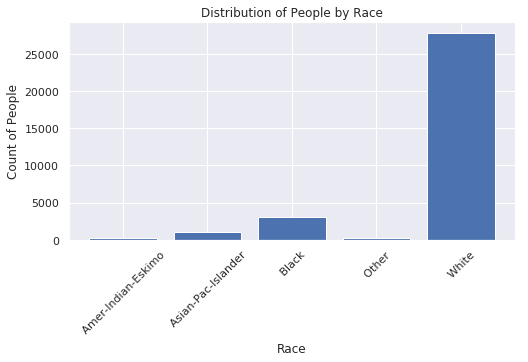

In [10]:
grouped_by_race = data[["race"]].groupby('race').size().reset_index(name="Count")

f = plt.figure(figsize=(8,4))

ax1 = f.add_subplot(111)
ax1.bar(grouped_by_race["race"],grouped_by_race["Count"])
ax1.set_xlabel("Race")
ax1.set_ylabel("Count of People")
ax1.set_xticklabels(grouped_by_race['race'], rotation=45)
ax1.set_title("Distribution of People by Race")

plt.show()

__The percentage of white people in the dataset is significantly higher compared to people from other races.__

In [11]:
grouped_by_race = data.groupby(['race','education']).size().reset_index(name="Count")

In [12]:
grouped_salary_by_race = data.groupby(['race','education']).size().reset_index(name="Count")
grouped_salary_by_race = grouped_salary_by_race.pivot(index='race', columns='education').reset_index("race")
grouped_salary_by_race.columns = ['race','10th','11th','12th','1st-4th','5th-6th',
                                  '7th-8th','9th','Assoc-acdm','Assoc-voc','Bachelors','Doctorate',
                                  'HS-grad','Masters','Preschool','Prof-school','Some-college']

grouped_salary_by_race = grouped_salary_by_race[['race','Preschool','1st-4th','5th-6th','7th-8th',
                                                 '9th','10th','11th','12th','HS-grad',
                                                 'Some-college','Bachelors',
                                                 'Masters','Prof-school','Doctorate']]

grouped_salary_by_race

,race,Preschool,1st-4th,5th-6th,7th-8th,9th,10th,11th,12th,HS-grad,Some-college,Bachelors,Masters,Prof-school,Doctorate
0,Amer-Indian-Eskimo,NaN,4.0,2.0,9.0,5.0,16.0,14.0,5.0,119.0,79.0,21.0,5.0,2.0,3.0
1,Asian-Pac-Islander,6.0,5.0,18.0,11.0,9.0,13.0,21.0,9.0,226.0,208.0,289.0,88.0,41.0,28.0
2,Black,5.0,16.0,21.0,56.0,89.0,133.0,153.0,70.0,1174.0,746.0,330.0,86.0,15.0,11.0
3,Other,2.0,9.0,13.0,17.0,8.0,9.0,10.0,14.0,78.0,51.0,33.0,7.0,4.0,2.0
4,White,38.0,134.0,279.0,553.0,403.0,762.0,977.0,335.0,8904.0,6207.0,4682.0,1537.0,514.0,369.0


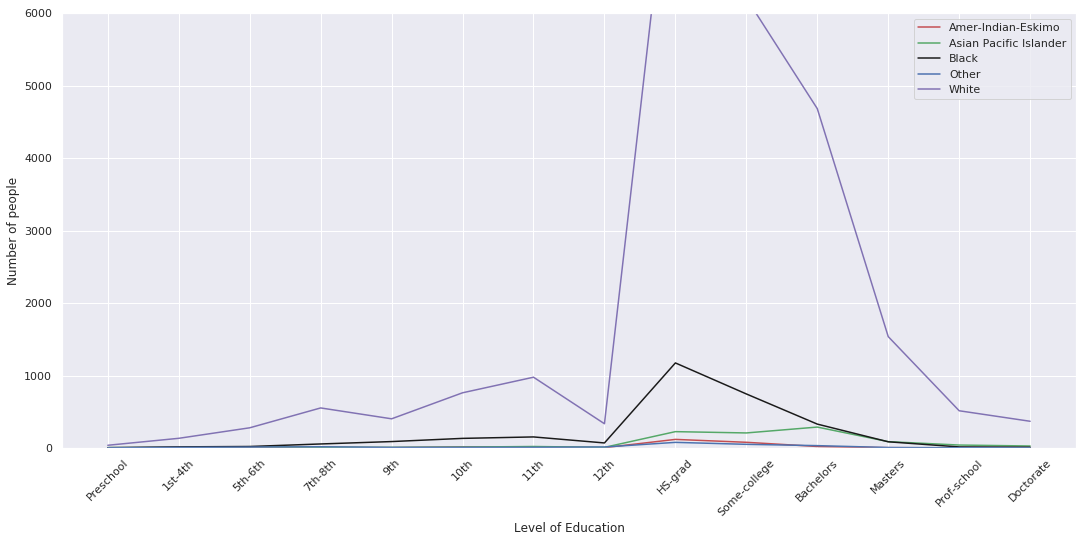

In [13]:
education_amer_indian_eskimo = list(grouped_salary_by_race.iloc[0])[1:]
education_asian_pac_islander = list(grouped_salary_by_race.iloc[1])[1:]
education_black = list(grouped_salary_by_race.iloc[2])[1:]
education_other = list(grouped_salary_by_race.iloc[3])[1:]
education_white = list(grouped_salary_by_race.iloc[4])[1:]

levels = ['Preschool','1st-4th','5th-6th','7th-8th','9th','10th','11th',
          '12th','HS-grad', 'Some-college',
          'Bachelors','Masters','Prof-school','Doctorate']

f = plt.figure(figsize=(40,8))
ax1 = f.add_subplot(121)
ax1.plot(levels,education_amer_indian_eskimo, color="r", label="Amer-Indian-Eskimo")
ax1.plot(levels,education_asian_pac_islander, color="g", label="Asian Pacific Islander")
ax1.plot(levels,education_black, color="k", label="Black")
ax1.plot(levels,education_other, color="b", label="Other")
ax1.plot(levels,education_white, color="m", label="White")
ax1.set_xticklabels(levels, rotation=45)

ax1.set_ylim(bottom=0, top=6000)

ax1.set_xlabel("Level of Education")
ax1.set_ylabel("Number of people")
ax1.legend()
plt.show()

__It seems a good number of people stop their education as a High School graduate. And the number of people 
who goes into higher degrees drops down afterwards. This trend seems to be consistant with all races except for Asian 
Pacific Americans (Islanders)__


Line graph helps to detect the change of slope, and compare the differences between various races without
confusion. The difference in color coding helps to distingush different groups of people


Note: The top portion of the graph has been clipped for greater clarity of the overlapped lines at the bottom

__Feature Correlations__

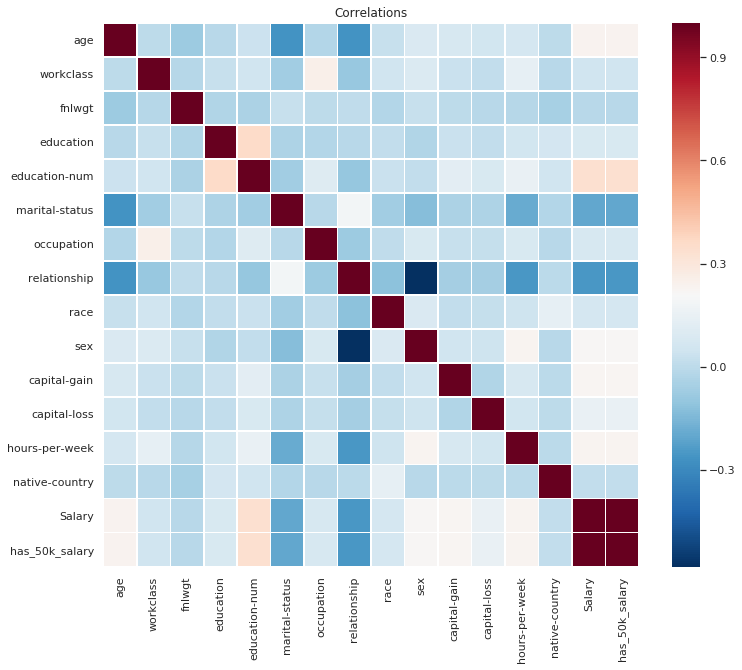

In [28]:
## Encoding to display the correlations
## https://stackoverflow.com/questions/29432629/correlation-matrix-using-pandas - Seaborn's heatmap

def encode_objects(df_):
    # we dont want the original data to be modified - using shallow copy
    df = df_.copy()
    for column in df.columns:
        if df.dtypes[column] == np.object:
            enc = LabelEncoder()
            df[column] = enc.fit_transform(df[column])
    return df


# Calculate the correlation and plot it
f = plt.figure(figsize=(12,10))
ax1 = f.add_subplot(111)
data_ = encode_objects(data)
correlations = data_.corr()
g1 = sns.heatmap(correlations, linewidths=.5, cmap = "RdBu_r")
ax1.set_title("Correlations")

plt.show()

__The blocks in brownish shades are the feature combinations to look for. 
Education & Education number seems to have High Correlation, 
Education number and Salary have a slightly less correlation in comparison, although positive.__

__Salary and has_50k_salary  has perfect correlation since our custom variable which was built from Salary - this is expected__

## Part 4

In [15]:
X = data[['age', 'workclass', 'fnlwgt', 'education',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']]
y = data['has_50k_salary']

In [16]:
X.head()

,age,workclass,fnlwgt,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,State-gov,77516,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,53,Private,234721,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,28,Private,338409,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba


__Splitting the data__

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.reset_index(inplace=True)
X_test.reset_index(inplace=True)

__Workclass, education marital-status, occupation, relationship, race, sex and native-country are categorical - 
we need to One-Hot encode them__

In [18]:
workclass_ohe = OneHotEncoder()
education_ohe = OneHotEncoder()
marital_ohe = OneHotEncoder()
relationship_ohe = OneHotEncoder()
race_ohe = OneHotEncoder()
country_ohe = OneHotEncoder()

## Transforming train dataframe


tmp = workclass_ohe.fit_transform(X_train.workclass.values.reshape(-1,1)).toarray()
workclass = pd.DataFrame(tmp, 
                         columns = [("workclass_"+str(int(i))) for i in range(tmp.shape[1])],
                         dtype = int)
tmp = education_ohe.fit_transform(X_train.education.values.reshape(-1,1)).toarray()
educlass = pd.DataFrame(tmp, 
                        columns = [("educlass_"+str(int(i))) for i in range(tmp.shape[1])],
                        dtype = int)

tmp = marital_ohe.fit_transform(X_train["marital-status"].values.reshape(-1,1)).toarray()
maritalclass = pd.DataFrame(tmp, 
                            columns = [("maritalclass_"+str(int(i))) for i in range(tmp.shape[1])],
                            dtype = int)

tmp = relationship_ohe.fit_transform(X_train.relationship.values.reshape(-1,1)).toarray()
relationclass = pd.DataFrame(tmp, 
                             columns = [("relationclass_"+str(int(i))) for i in range(tmp.shape[1])],
                             dtype = int)

tmp = race_ohe.fit_transform(X_train.race.values.reshape(-1,1)).toarray()
raceclass = pd.DataFrame(tmp, 
                         columns = [("raceclass_"+str(int(i))) for i in range(tmp.shape[1])],
                         dtype = int)

tmp = country_ohe.fit_transform(X_train["native-country"].values.reshape(-1,1)).toarray()
countryclass = pd.DataFrame(tmp, 
                         columns = [("countryclass_"+str(int(i))) for i in range(tmp.shape[1])],
                         dtype = int)

__Apply the same transformations on test data__

In [19]:
## Using the same transformers to transform test dataframe

tmp = workclass_ohe.transform(X_test.workclass.values.reshape(-1,1)).toarray()
workclassTest = pd.DataFrame(tmp, 
                             columns = [("workclass_"+str(int(i))) for i in range(tmp.shape[1])],
                             dtype = int)
tmp = education_ohe.transform(X_test.education.values.reshape(-1,1)).toarray()
educlassTest = pd.DataFrame(tmp, 
                            columns = [("educlass_"+str(int(i))) for i in range(tmp.shape[1])],
                            dtype = int)

tmp = marital_ohe.transform(X_test["marital-status"].values.reshape(-1,1)).toarray()
maritalclassTest = pd.DataFrame(tmp, 
                                columns = [("maritalclass_"+str(int(i))) for i in range(tmp.shape[1])],
                                dtype = int)

tmp = relationship_ohe.transform(X_test.relationship.values.reshape(-1,1)).toarray()
relationclassTest = pd.DataFrame(tmp, 
                                 columns = [("relationclass_"+str(int(i))) for i in range(tmp.shape[1])],
                                 dtype = int)

tmp = race_ohe.transform(X_test.race.values.reshape(-1,1)).toarray()
raceclassTest = pd.DataFrame(tmp, 
                             columns = [("raceclass_"+str(int(i))) for i in range(tmp.shape[1])],
                             dtype = int)

tmp = country_ohe.transform(X_test["native-country"].values.reshape(-1,1)).toarray()
countryclassTest = pd.DataFrame(tmp, 
                                 columns = [("countryclass_"+str(int(i))) for i in range(tmp.shape[1])],
                                 dtype = int)

In [20]:
#scaling numeric features
scaler = StandardScaler(copy=False)
X_train[["capital-gain", "capital-loss"]] = scaler.fit_transform(X_train[["capital-gain", "capital-loss"]])
X_test[["capital-gain", "capital-loss"]] = scaler.transform(X_test[["capital-gain", "capital-loss"]])

In [21]:
X_train = X_train[["age", "capital-gain", "capital-loss", "hours-per-week"]]
X_test = X_test[["age", "capital-gain", "capital-loss", "hours-per-week"]]

X_train = pd.concat([X_train, workclass, educlass, maritalclass, relationclass, raceclass, countryclass], axis=1)
X_test = pd.concat([X_test, workclassTest, educlassTest, maritalclassTest, relationclassTest, raceclassTest, countryclassTest], axis=1)

__Done with preprocessing. Let's  train the classifier now!__


Parameters to Optimize:

__k__ : Number of neighbours

__p__ : Distance Type (1 = Manhattan Distance, 2 = Euclidean Distance)


Since the dataset is imbalanced, __AUC__ and __F1__ scores are used as the evaluation metric.

__Ideas adoped from:  https://qiita.com/bmj0114/items/8009f282c99b77780563__

__Searching for Optimal Hyperparameters__

In [30]:
model = KNeighborsClassifier()

n_neighbors = list(range(1,11))
p = [1,2]

tuned_parameters = [{'n_neighbors': n_neighbors, 'p':p}]
scores = ['f1']


def f1_scorer(target, pred):
    score = f1_score(pred, target)    
    return score

def auc_scorer(target, pred):
    auc = roc_auc_score(pred, target)    
    return auc


auc_scorer = make_scorer(auc_scorer, greater_is_better=True)
#balanced_accuracy_scorer = make_scorer(balanced_accuracy_scorer, greater_is_better=True)
f1_scorer = make_scorer(f1_scorer, greater_is_better=True)

scorers = [auc_scorer, f1_scorer]

scores_for_grid1 = []
scores_for_grid2 = []

combination_top_scores = []

# n_jobs = -1 : max performance (use all my compute power!)
for i in range(len(scorers)):
    clf = GridSearchCV(model, 
                       tuned_parameters, 
                       cv=10,
                       scoring=scorers[i],
                       n_jobs=-1)
    
    clf.fit(X_train, y_train)
    
    if i == 0:
        scores_for_grid1 = [clf.cv_results_['split1_test_score'],
                            clf.cv_results_['split2_test_score'],
                            clf.cv_results_['split3_test_score'],
                            clf.cv_results_['split4_test_score'],
                            clf.cv_results_['split5_test_score'],
                            clf.cv_results_['split6_test_score'],
                            clf.cv_results_['split7_test_score'],
                            clf.cv_results_['split8_test_score'],
                            clf.cv_results_['split9_test_score']]
    if i == 1:
        scores_for_grid2 = [clf.cv_results_['split1_test_score'],
                            clf.cv_results_['split2_test_score'],
                            clf.cv_results_['split3_test_score'],
                            clf.cv_results_['split4_test_score'],
                            clf.cv_results_['split5_test_score'],
                            clf.cv_results_['split6_test_score'],
                            clf.cv_results_['split7_test_score'],
                            clf.cv_results_['split8_test_score'],
                            clf.cv_results_['split9_test_score']]
       
    print("Best parameters set found on development set for scorer index " + str(i) + ":")
    print(clf.best_params_)
    
    combination_top_scores.append(clf.cv_results_['mean_test_score'].reshape(len(n_neighbors),len(p)))
    
    

Best parameters set found on development set for scorer index 0:
{'n_neighbors': 10, 'p': 1}
Best parameters set found on development set for scorer index 1:
{'n_neighbors': 9, 'p': 1}


In [31]:
# keeping p=1, get the scores for different values of k
def filter_odd(l):
    return [l[i] for i in range(len(l)) if i%2 == 0]

scores_auc = [filter_odd(x) for x in scores_for_grid1]
scores_f1 = [filter_odd(x) for x in scores_for_grid2]

## Visualization 3

Text(0.5, 1.0, 'Variation of AUC scores in each iteration with different number of neighbors')

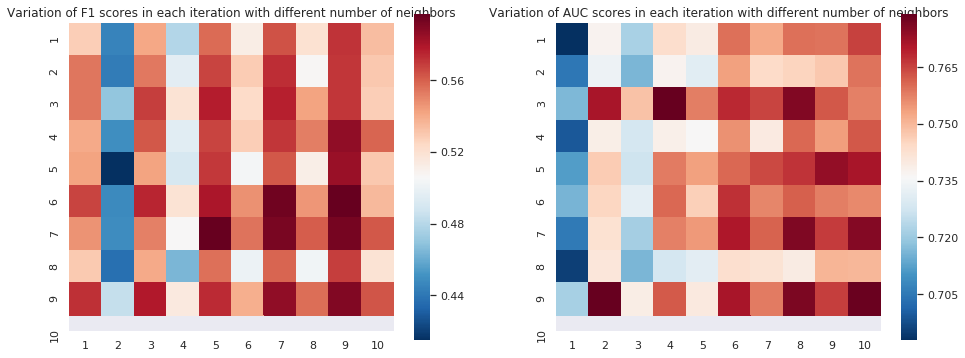

In [32]:
xticklabels = list(range(1,11,1))
yticklabels = list(range(1,11,1))


f = plt.figure(figsize=(16, 6))
 
ax1 = f.add_subplot(121)
ax1 = sns.heatmap(scores_f1, 
                square=True, 
                xticklabels=xticklabels, 
                yticklabels=yticklabels,
                cmap="RdBu_r")
        
ax1.set_title('Variation of F1 scores in each iteration with different number of neighbors')


ax2 = f.add_subplot(122)
ax2 = sns.heatmap(scores_auc, 
                square=True, 
                xticklabels=xticklabels, 
                yticklabels=yticklabels,
                cmap="RdBu_r")
        
ax2.set_title('Variation of AUC scores in each iteration with different number of neighbors')


__X-axis__ : Number of neighbors
    
__Y-axis__ : CV iteration count    
    
Fixing, p = 1

As we can see, while using F1 as the metric, optimal value of number of neighbors = 9 

and that while using AUC as the metric is 10

## Visualization of best scores in each iteration for different p and num_neighbors values

In [33]:
#scores = clf.cv_results_['mean_test_score'].reshape(len(n_neighbors),len(p))
combination_top_scores[0]

# format [[n=1,p =1],[n=1,p=2],[n=2,p=1],,[n=2,p=2],[n=3,p=1]....]

array([[0.70463395, 0.70413434],
       [0.74613848, 0.7459135 ],
       [0.72663965, 0.72433943],
       [0.74842438, 0.74418058],
       [0.74149609, 0.73938328],
       [0.75835886, 0.75494446],
       [0.75205441, 0.74478831],
       [0.76043396, 0.75341908],
       [0.75780141, 0.74798709],
       [0.76303923, 0.75926899]])

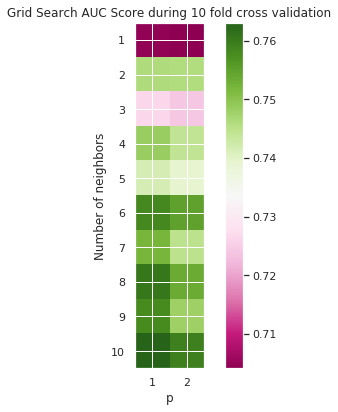

In [34]:
plt.figure(figsize=(8, 6))

plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(combination_top_scores[0], interpolation='nearest', cmap='PiYG')
plt.xlabel('p')
plt.ylabel('Number of neighbors')
plt.colorbar()
plt.yticks(np.arange(len(n_neighbors)), n_neighbors)
plt.xticks(np.arange(len(p)), p)
plt.title('Grid Search AUC Score during 10 fold cross validation')
plt.show()

In [35]:
combination_top_scores[1]

array([[0.54509879, 0.546294  ],
       [0.4458094 , 0.4523631 ],
       [0.55513068, 0.55760469],
       [0.49418536, 0.49131053],
       [0.56867547, 0.56879952],
       [0.52261943, 0.52013505],
       [0.5727809 , 0.56579225],
       [0.53123383, 0.52313689],
       [0.57872039, 0.5674759 ],
       [0.53704731, 0.53520716]])

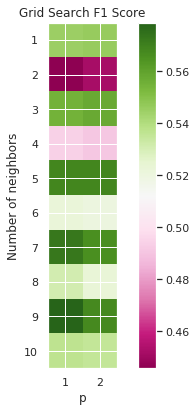

In [36]:
plt.figure(figsize=(8, 6))

plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(combination_top_scores[1], interpolation='nearest', cmap='PiYG')
plt.xlabel('p')
plt.ylabel('Number of neighbors')
plt.colorbar()
plt.yticks(np.arange(len(n_neighbors)), n_neighbors)
plt.xticks(np.arange(len(p)), p)
plt.title('Grid Search F1 Score')
plt.show()

__Optimal Hyperparameters (From F1)__

__p__ = 1

__n_neighbors__ = 9

In [37]:
knn_clf = KNeighborsClassifier(n_neighbors=9, p=1)
knn_clf.fit(X_train, y_train)
pred = knn_clf.predict(X_test)
pred

array([0, 1, 0, ..., 1, 0, 0])

__Calculating Performance of our model__

In [38]:
# How does the performance look like
f1score_test = f1_score(y_test, pred)
roc_auc_score_test = roc_auc_score(y_test, pred)


print("Test Performance")
print("F1 score:", f1score_test)
print("ROC AUC Score:", roc_auc_score_test)

Test Performance
F1 score: 0.5726744186046512
ROC AUC Score: 0.7110344412756402
